In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.iekf import IEKF
from tools.objects import Gaussian
from tools import compare, data_processing, transform
from tools.tools_ahrs import plot

In [2]:
x3_path = os.path.join("data", "TUM-VI", "imu0")
mocap_path = os.path.join("data", "TUM-VI", "mocap0")
take_name = "outdoors1.csv"

In [3]:
t_base, data_gyr, data_acc = data_processing.import_tum_imu(os.path.join(x3_path, take_name), smoothing=False)

In [4]:
downscale = 1
t_base, data_gyr, data_acc = data_processing.downsample(downscale, t_base, data_gyr, data_acc)

In [5]:
freq_my = 120/downscale # Hz
# if frequency of MoCap is lower than resulting from data - change to MoCap's 240 Hz

In [6]:
data_mocap_t, data_mocap_q, data_mocap_T = data_processing.import_tum_mocap(os.path.join(mocap_path, take_name), smoothing=False)

In [7]:
data_mocap_t, data_mocap_q, data_mocap_T = data_processing.downsample(downscale, data_mocap_t, data_mocap_q, data_mocap_T)

In [8]:
t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

In [9]:

x3_path_my = os.path.join("iekf", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
# x3_path = "madgwick_filter/recordings/X3_simple/standing_still_2025-03-05_19-11-59.134_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/basic_motions_2025-03-05_19-05-58.195_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/walking_2025-03-05_18-54-04.492_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/walking_talking_2025-03-05_19-01-51.858_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

mocap_path_my = os.path.join("iekf", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
# mocap_path = "madgwick_filter/recordings/Mocap_simple/standing_still_Take 2025-03-05 06.55.27 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/basic_motions_Take 2025-03-05 06.55.27 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/walking_Take 2025-03-05 06.55.27 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/walking_talking_Take 2025-03-05 06.55.27 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"


In [10]:
import_myrecording = False
if import_myrecording:
    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

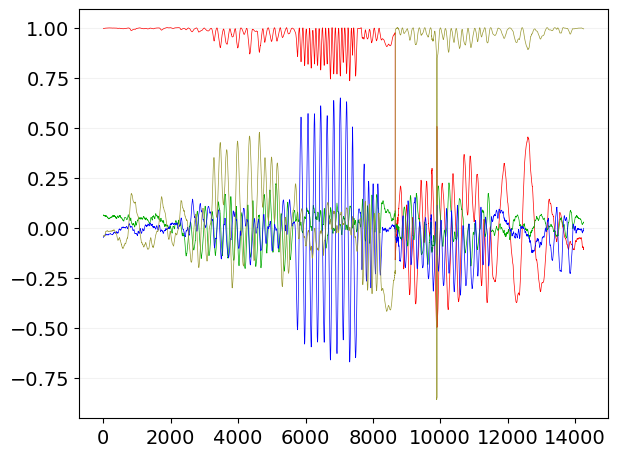

In [11]:
plot(data_mocap_q)

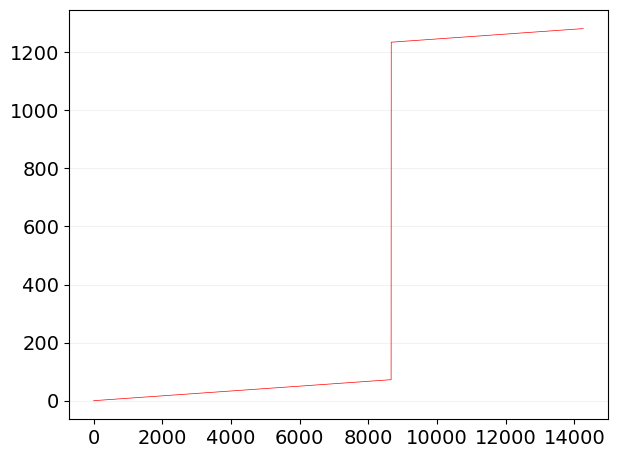

In [12]:
plot(data_mocap_t - data_mocap_t[0])

In [13]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-3 * np.eye(3, 3)                                 # rad/s
Q = 1e-1 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

In [14]:
for i in range(N):
    iekf.predict(u[i], dts[i])
    Ks[i], IVs[i] = iekf.update(data_acc[i])
    #iekf.update_fake()
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma

In [15]:
print(iekf.Sigma_bar)

[[ 8.52425530e-05  1.19251274e-06 -1.79950347e-05]
 [ 1.19251274e-06  8.27640818e-05 -8.55217458e-06]
 [-1.79950347e-05 -8.55217458e-06  2.61734764e-04]]


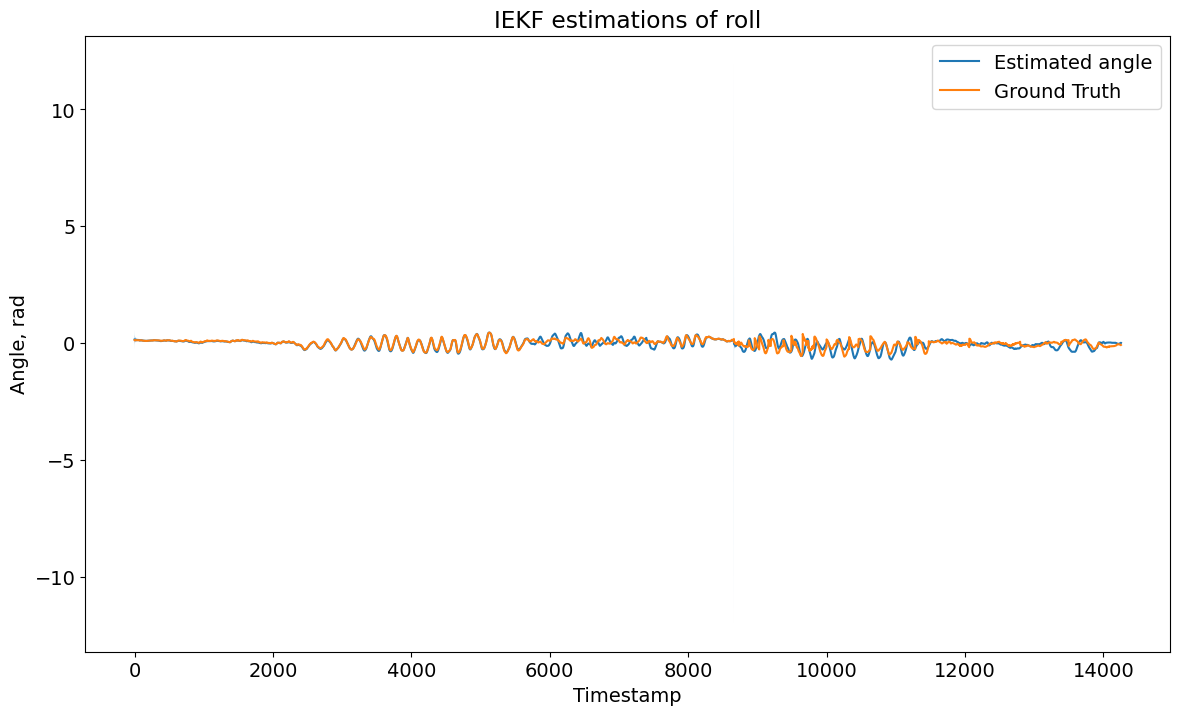

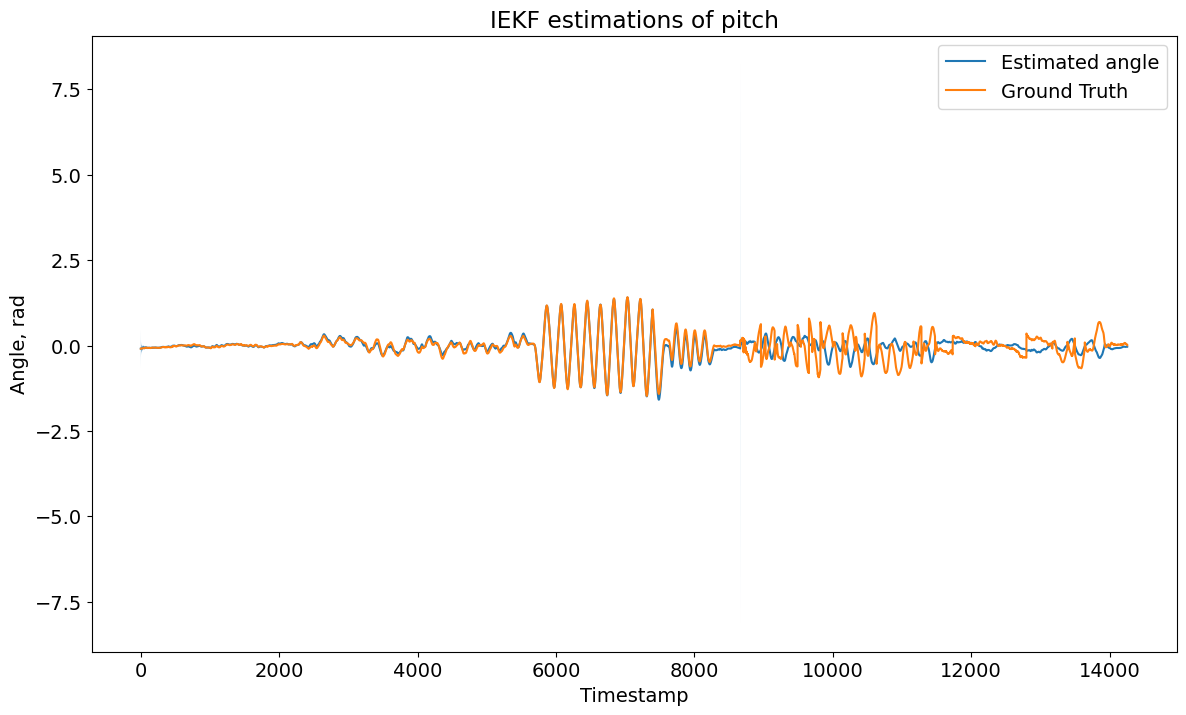

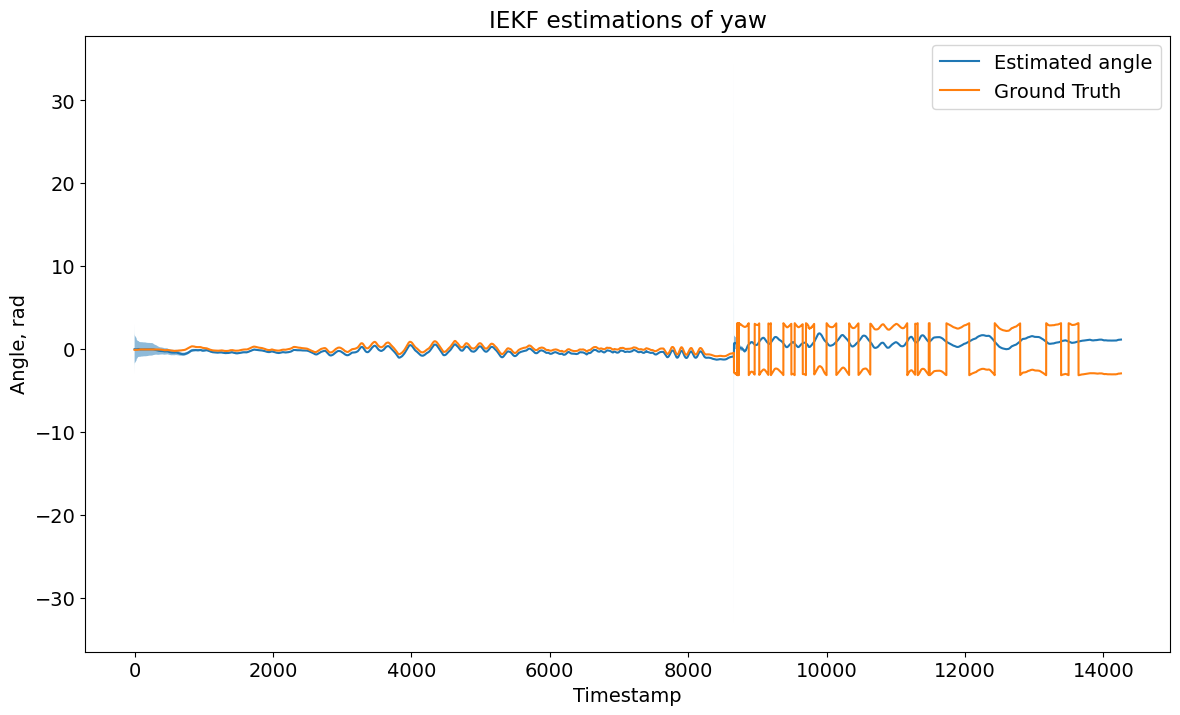

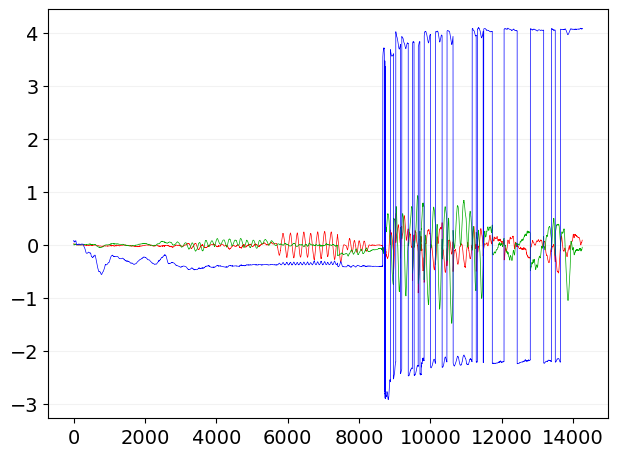

In [16]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

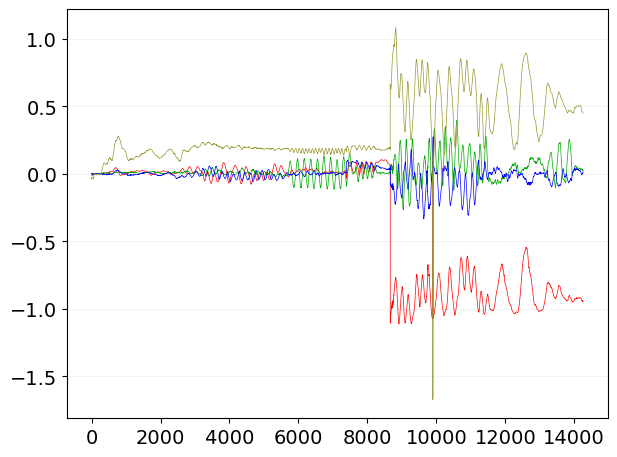

In [17]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)
plot(q1 - q2)

Mean distance between smartphone and mocap attitude estimations:
1.113724086525511
Distance between smartphone and mocap attitude estimations:


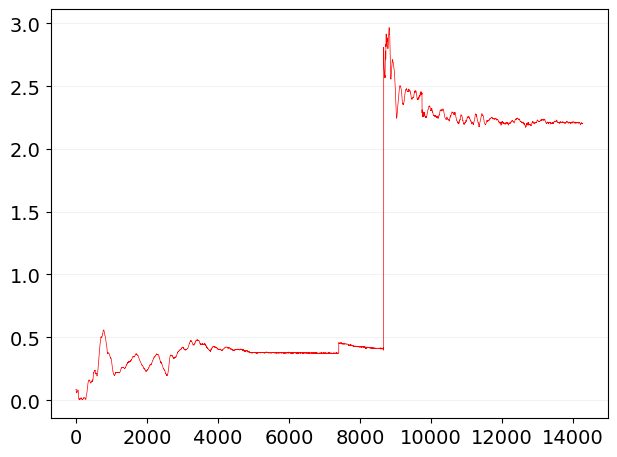

Last distance between smartphone and mocap attitude estimations:
2.202132623612749
Norm of quaternions - shall be = 1
[1. 1. 1. ... 1. 1. 1.]


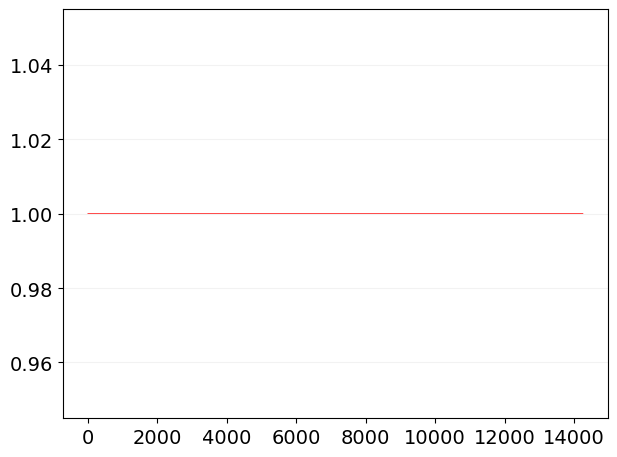

G vectors in smartphone and (mocap-observed-smartphone) reference frames


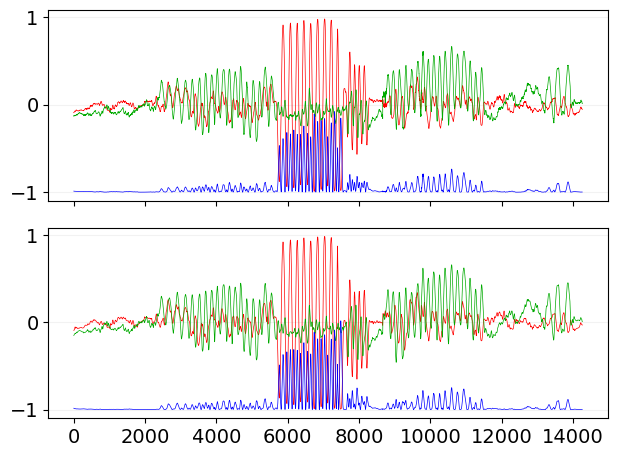

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


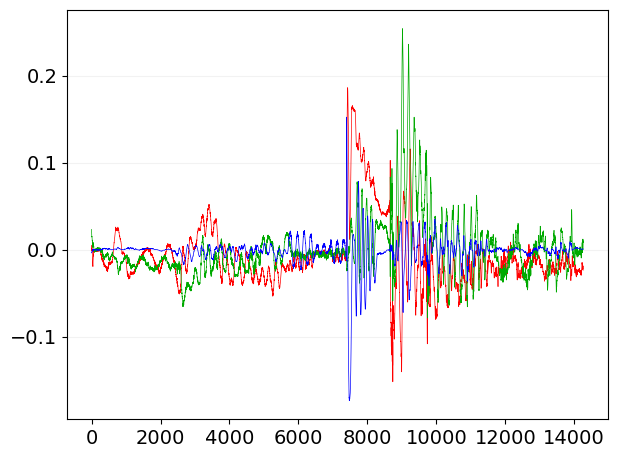

Mean distance between smartphone and mocap vector g estimations:
0.04073834350387703
Distance between smartphone and mocap vector g estimations:


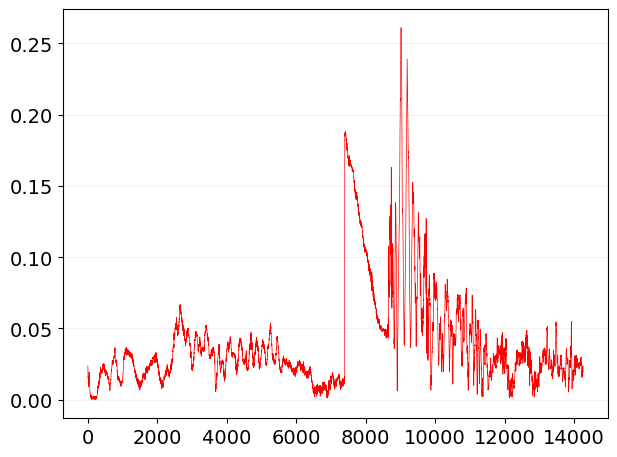

Last distance between smartphone and mocap vector g estimations:
0.02346766211516469
Mean Relative Pose Error
0.002594715576730678
Relative Pose Error


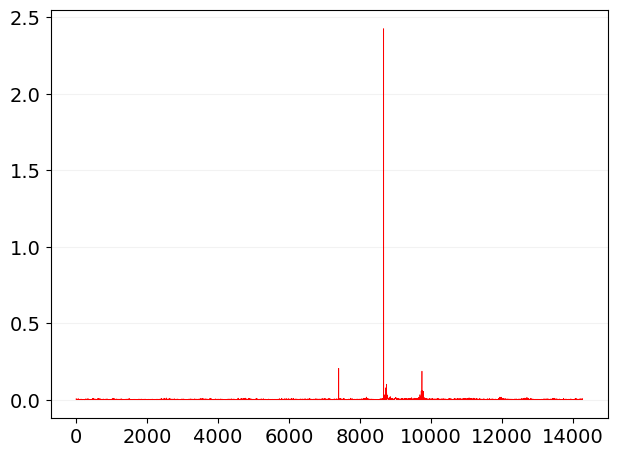

Last RPE between smartphone and mocap attitude estimations:
0.004743277229791819
Mean Relative Pose Error of vector g
0.006587527446424007
Relative Pose Error of vector g


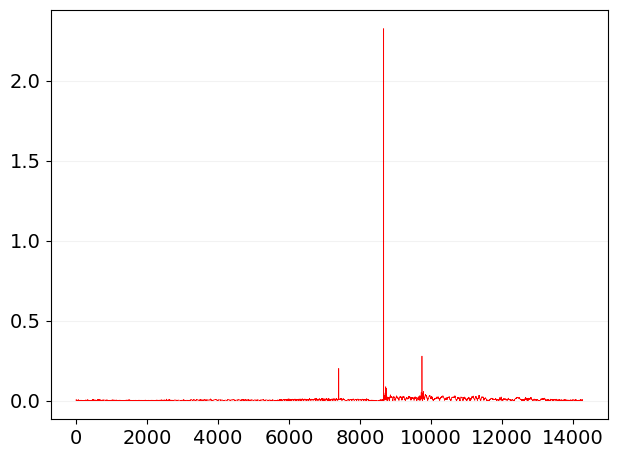

Last RPE between smartphone and mocap vector g estimations:
0.0066998057481162405


(array([0.08426125, 0.08673662, 0.08616213, ..., 2.20377317, 2.19912144,
        2.20213262]),
 array([0.02380192, 0.02078952, 0.01943407, ..., 0.01894813, 0.02011933,
        0.02346766]),
 array([0.00477655, 0.00182544, 0.0033624 , ..., 0.00727393, 0.00486999,
        0.00474328]),
 array([0.00398606, 0.00118155, 0.00276258, ..., 0.00311077, 0.00294312,
        0.00669981]))

In [18]:
compare.errors_estimation(q1, q2)